## PROJECT 3

In [95]:
import pandas as pd
import autograd.numpy as np
import autograd
import matplotlib.pyplot as plt
import matplotlib
import functools
import scipy.optimize
from scipy.integrate import solve_ivp
import pandas as pd

### Problem 1: using the functions from Project 2: Problem 2

In [96]:
def steady_heat(x,T_ambient, a,b,L, Phi, h, k):
    def gamma_func(a, b, k):
        return np.sqrt( (2*(a+b)*h) / (a*b*k))
    
    def c1_func(L, g, Phi, h, k):
        # g = gamma
        return - Phi/(k*g) * ((np.exp(g)**L)*(h + k*g)) * ((np.exp(-g)**L)*(h-k*g)+(np.exp(g)**L)*(h+k*g))**(-1)
    
    def c2_func(Phi, k, g, c_1):
        return Phi/(k*g) + c_1
       
    gamma = gamma_func(a,b, k)
    c1 = c1_func(L, gamma, Phi, h, k)
    c2 = c2_func(Phi, k, gamma, c1)
    
    return c1*np.exp(-gamma * x) + c2*np.exp(gamma*x) + T_ambient

def optimize_me(x, Phi, h, k):
    T_ambient = 21.29
    a = 0.96
    b = a
    L = 70
    
    def gamma_func(a, b, k):
        return np.sqrt( (2*(a+b)*h) / (a*b*k))
    
    def c1_func(L, g, Phi, h, k):
        # g = gamma
        return - Phi/(k*g) * ((np.exp(g)**L)*(h + k*g)) * ((np.exp(-g)**L)*(h-k*g)+(np.exp(g)**L)*(h+k*g))**(-1)
    
    def c2_func(Phi, k, g, c_1):
        return Phi/(k*g) + c_1
       
    gamma = gamma_func(a,b, k)
    c1 = c1_func(L, gamma, Phi, h, k)
    c2 = c2_func(Phi, k, gamma, c1)
    
    return c1*np.exp(-gamma * x) + c2*np.exp(gamma*x) + T_ambient

C:\Users\adamc\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


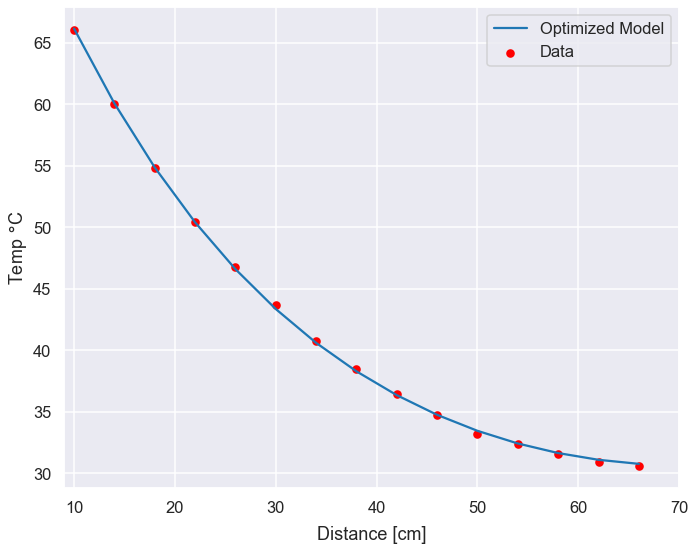

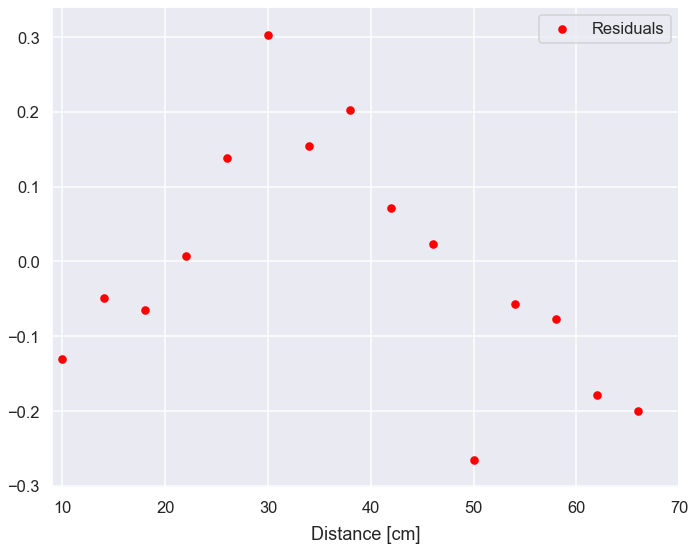

In [97]:
# Phi, h, k = -18.4, 0.00191, 2.37  # OLD FROM AL MODEL
step = 1e-4
T_amb = 21.29
a = 0.96
b = a
L = 70

x_domain = np.arange(10, 70, 4)

# FROM TABLE 3.3 of the TEXTBOOK!!!
Y = [66.04, 60.04, 54.81, 50.42, 46.74, 43.66, 40.76, 38.49,
    36.42, 34.77, 33.18, 32.36, 31.56, 30.91, 30.56]

Y_AL = [96.14, 80.12, 67.66, 57.96, 50.90, 44.84, 39.75, 39.16,
       33.31, 31.15, 29.28, 27.88, 27.18, 26.40, 25.86]

best_vals, covar = scipy.optimize.curve_fit(optimize_me, x_domain, Y, p0=[20, 0.002, 3])

f_q = optimize_me(x_domain ,*best_vals)
R = Y - f_q
Phi, h, k =  best_vals

fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
plt.scatter(x_domain, Y,  s=50, c='r',label='Data')
plt.plot(x_domain, f_q, label="Optimized Model")
axe.set_xlabel('Distance [cm]', labelpad=10);
axe.set_ylabel('Temp $\degree$C');
plt.xlim(9, 70)
plt.legend()
plt.tight_layout()

fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
plt.scatter(x_domain, R, s=50, c='r', label="Residuals")
axe.set_xlabel('Distance [cm]', labelpad=10);
plt.xlim(9, 70)
plt.legend()
plt.tight_layout()

In [98]:
# f_q = steady_heat(x_domain, T_amb, a,b,L, Phi, h, k)
# R = Y - f_q

dy_dPhi_auto = autograd.grad(steady_heat, 5) # take heat function, differentiate with respect to variable 5, returns a new function that is dy /dPhi
dy_dPhi_auto_values = [dy_dPhi_auto(x, T_amb, a, b, L, Phi, h, k) for x in x_domain] # evaluate new function at points and pass extra parameters

dy_dh_auto = autograd.grad(steady_heat, 6)
dy_dh_auto_values = [dy_dh_auto(x, T_amb, a, b, L, Phi, h, k) for x in x_domain]

Chi_matrix = np.stack((np.asarray(dy_dPhi_auto_values),np.asarray(dy_dh_auto_values)), axis=1)

n, p = Chi_matrix.shape[0], Chi_matrix.shape[1]  # 15 observations or rows, and # 2 vars or cols
var = (1 / (n-p))* np.linalg.inv(np.matmul(np.transpose(Chi_matrix), Chi_matrix))
print(var)   # Covariance Matrix

[[ 2.82218492e-01 -3.70631919e-05]
 [-3.70631919e-05  5.26084098e-09]]


### Problem 2: using the functions from Project 2: Problem 3

In [99]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

def PSI(P, q):
    return q[0]*P**2 + q[1]*P**4 + q[2]*P**6

(a)

In [100]:
a_1, a_11, a_111 = -389.4, 761.3, 61.5
q = [a_1, a_11, a_111]
sigma = 2.2  # Error is IID and Normal with STD or Sigma = 2.2

interval_size = [81, 161, 801]  # number of equally spaces polarization values
P_array = [[] for i in range (3)]
Y_array = [[] for i in range (3)]

for i in range (3):
    P_array[i] = np.linspace(0, 0.8, interval_size[i])  # fill intervals
    Y_array[i] = PSI(P_array[i], q) + np.random.normal(0, 2.2, interval_size[i])



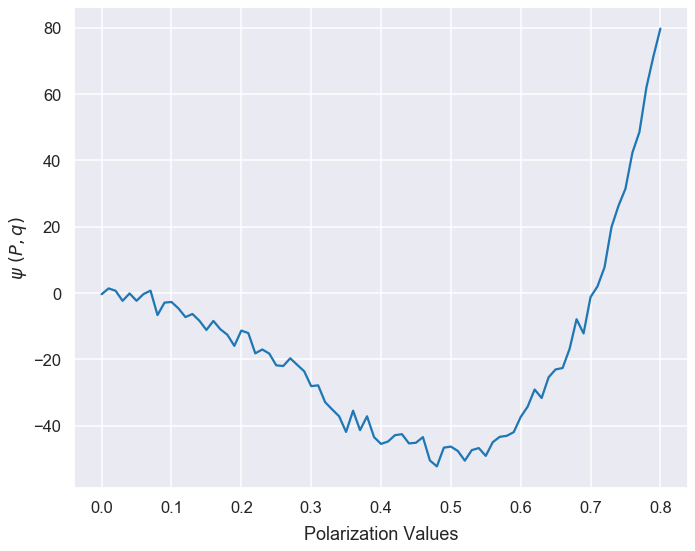

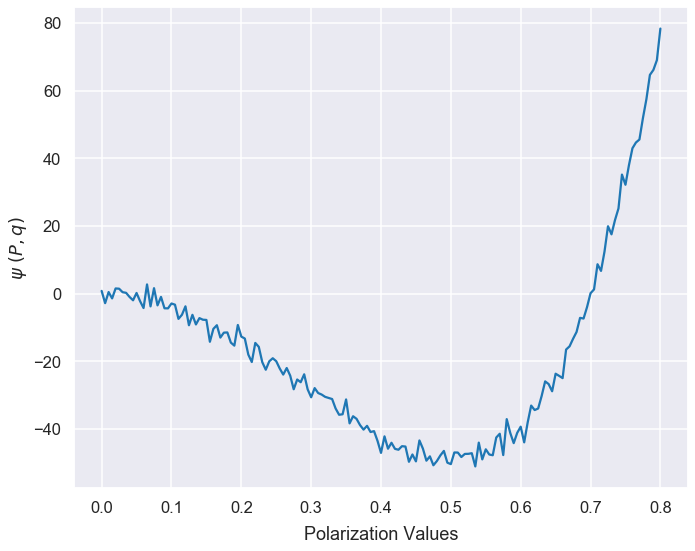

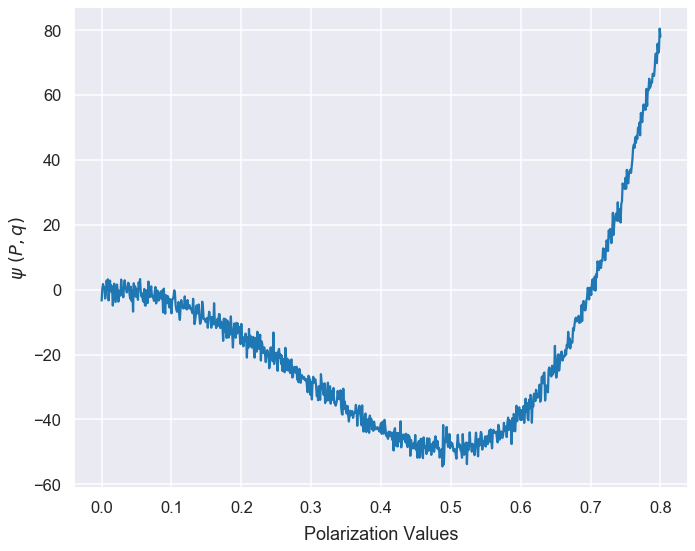

In [101]:
for i in range (3):

    fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
    axe=sns.lineplot(P_array[i], Y_array[i])
    axe.set_xlabel('Polarization Values', labelpad=10);
    axe.set_ylabel('$\psi \ (P,q)$');
    plt.tight_layout()

In [102]:
calculated_variance = np.zeros(3)

for i in range(3):
    calculated_variance[i] = (1 / (interval_size[i] - len(q))) * np.matmul(np.transpose(Y_array[i]-PSI(P_array[i], q)), Y_array[i]-PSI(P_array[i], q))

In [103]:
np.sqrt(calculated_variance)


array([2.3856435 , 2.18939794, 2.18111486])

(b)

In [104]:
def design_matrix(x):
    size = x.shape[0]
    p = 3
    DM = np.zeros((size, p))
    
    for i in range(size):
        DM[i, :] = np.array([x[i]**2, x[i]**4, x[i]**6])
    
    return DM 

# FOR Chi Matrix -> Sensitivity Matrix
def dy_da_1(P):
    return P**3 / 3

def dy_da_11(P):
    return P**5 /5

def dy_da_111(P):
    return P**7 / 7

In [105]:
X = design_matrix(P_array[1])
q_ols = np.linalg.inv(np.transpose(X)@X)@np.transpose(X)@Y_array[1]
Res = Y_array[1] - PSI(P_array[1], q_ols)
var_P = (1 / (161-3))*(np.transpose(Res)@Res)
sigma_estimated = np.sqrt(var_P)
print(f'Estimated Standard Deviation: {sigma_estimated:.2f}')

Chi = np.column_stack((dy_da_1(P_array[1]),dy_da_11(P_array[1]), dy_da_111(P_array[1])))
covar_P = var_P*np.linalg.inv(np.transpose(Chi)@Chi)
covar_P

Estimated Standard Deviation: 2.18


array([[  1074.26962753,  -8032.88690023,  11908.07080711],
       [ -8032.88690023,  63185.68240984, -96868.44420969],
       [ 11908.07080711, -96868.44420969, 152104.86672985]])

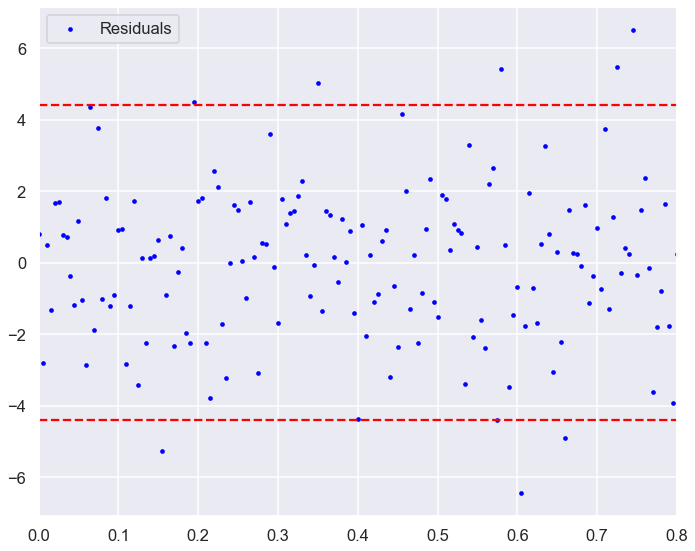

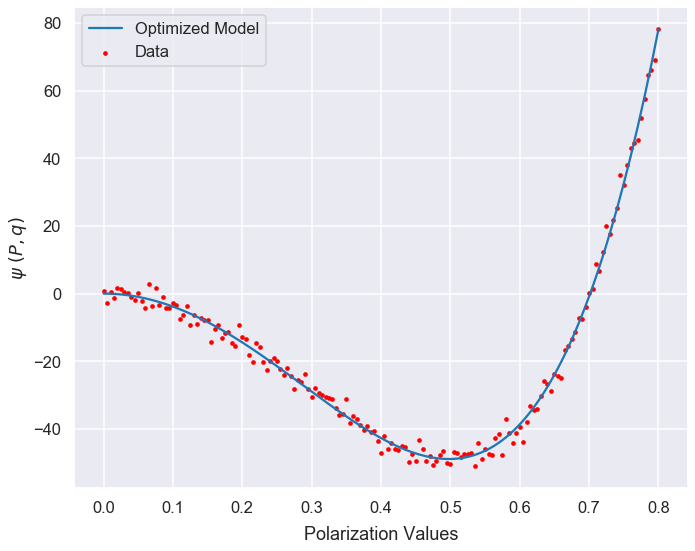

In [134]:
fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
plt.scatter(P_array[1], Res, s=10, c='b', label="Residuals")
plt.hlines(2*sigma, 0, 0.8, colors='r', linestyles='--')
plt.hlines(-2*sigma, 0, 0.8, colors='r', linestyles='--')
plt.xlim(0, 0.8)
plt.legend()
plt.tight_layout()

fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
plt.scatter(P_array[1], Y_array[1], s=10, c='r', label='Data')
plt.plot(P_array[1], PSI(P_array[1], q_ols), label="Optimized Model")
axe.set_xlabel('Polarization Values', labelpad=10);
axe.set_ylabel('$\psi \ (P,q)$');
plt.legend()
plt.tight_layout()

Problem 3

In [107]:
def SIR(t, Y, delta, gamma, r):
    S, I, R = Y[0], Y[1], Y[2]
    N = S + I + R
    
    dS_dt = delta*N - delta*S - gamma*I*S
    dI_dt = gamma*I*S - (r+delta)*I
    dR_dt = r*I - delta*R
    
    return [dS_dt, dI_dt, dR_dt ]

df = pd.read_csv('SIR.txt', header=None, delim_whitespace=True)
SIR_DATA = pd.DataFrame.to_numpy(df)
y = SIR_DATA[:, 1]


def fun(q, t, y, Y_0):
    t_domain = t
    sol = solve_ivp(SIR,[0, 5], Y_0,args=(q[0], q[1], q[2]), t_eval=t_domain)
    
    minimize_me = 0
    for i in range(51):
        minimize_me += (sol.y[1][i] - y[i])**2    
    
    return minimize_me
    

In [131]:
Y_0 = [900, 100, 0]
t_domain = np.linspace(0, 5, 51)

In [132]:
solution = scipy.optimize.minimize(fun, [1, 2,  3], args=(t_domain, y, Y_0), bounds=((0, 1), (0, 1), (0, 1)))
solution

      fun: 829670.8462320988
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.74622983e+00, -3.20054824e+03, -7.56699592e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 18
   status: 0
  success: True
        x: array([0.15991786, 1.        , 0.76178701])

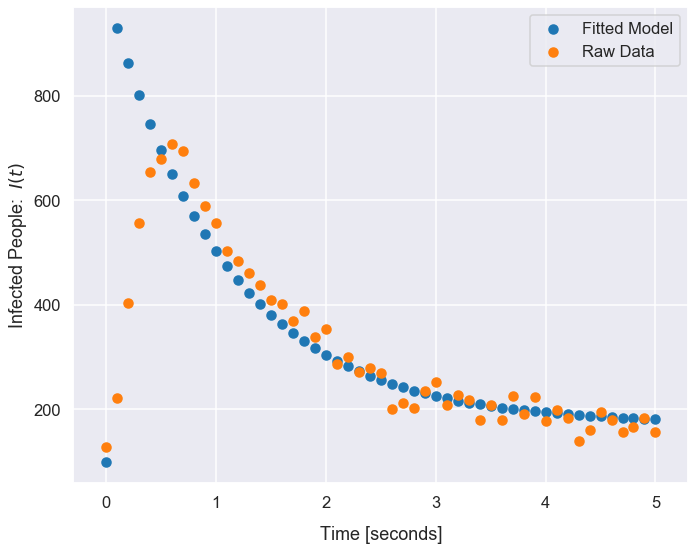

In [140]:
fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
sol = solve_ivp(SIR,[0, 5], Y_0,args=solution.x, t_eval=t_domain)
plt.scatter(t_domain, sol.y[1], label='Fitted Model')
plt.scatter(SIR_DATA[:,0], y, label='Raw Data')
plt.ylabel('Infected People:  '+r'$I(t)$')
plt.xlabel('Time [seconds]', labelpad=15)
plt.legend()
plt.tight_layout()

In [142]:
sol.y[1]

array([100.        , 928.66874333, 862.16079042, 801.50804509,
       746.19447716, 695.75071295, 649.74721646, 607.79362344,
       569.53338735, 534.64043788, 502.81930476, 473.79984396,
       447.33419489, 423.19788289, 401.18564938, 381.11222836,
       362.80523566, 346.11044095, 330.8839706 , 316.9994553 ,
       304.33538421, 292.78815352, 282.25742488, 272.65318537,
       263.8946488 , 255.90874748, 248.62605695, 241.98372499,
       235.92798309, 230.40529065, 225.36847189, 220.77734628,
       216.59069861, 212.7721187 , 209.29159869, 206.11749485,
       203.22310756, 200.58386135, 198.17801919, 195.98432963,
       193.98435836, 192.16126318, 190.49626053, 188.98238515,
       187.60050019, 186.33991201, 185.19197179, 184.14400314,
       183.18976577, 182.31978342, 181.52594339])